# Prepare Data

Plan - Acquire - **Prepare** - Explore - Model - Deliver

**Goal**: Prepare, tidy, and clean the data so that it is ready for exploration and analysis.

**Input:** 1 or more dataframes acquired through the "acquire" step.

**Output:** 1 dataset split into 3 samples in the form of dataframes: train, validate & test.

**Artifact:** `prepare.py`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import acquire

In [2]:
# acquire titanic data

df = acquire.get_titanic_data()

## STEP 1: Summarizing

In [3]:
# rows & columns?
df.shape

(891, 13)

In [4]:
# look for data dictionary

In [5]:
# view first n rows
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [6]:
# Get information about the dataframe: column names, rows, datatypes, non-missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   sex           891 non-null    object 
 4   age           714 non-null    float64
 5   sibsp         891 non-null    int64  
 6   parch         891 non-null    int64  
 7   fare          891 non-null    float64
 8   embarked      889 non-null    object 
 9   class         891 non-null    object 
 10  deck          203 non-null    object 
 11  embark_town   889 non-null    object 
 12  alone         891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ KB


In [7]:
# Get summary statistics for numeric columns.
df.describe()

,passenger_id,survived,pclass,age,sibsp,parch,fare,alone
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.602694
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.489615
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,667.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


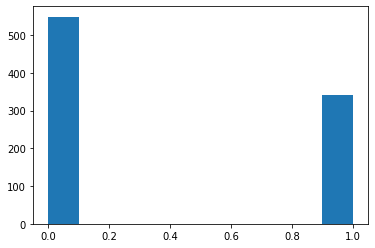

In [8]:
# Check out distributions of numeric columns.
plt.hist(df['survived']);

In [9]:
num_cols = df.select_dtypes(include = 'number').columns
num_cols

Index(['passenger_id', 'survived', 'pclass', 'age', 'sibsp', 'parch', 'fare',
       'alone'],
      dtype='object')

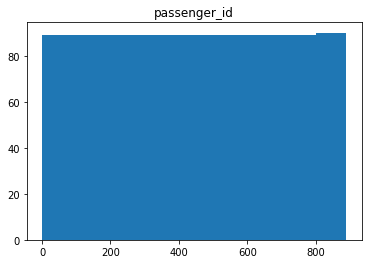

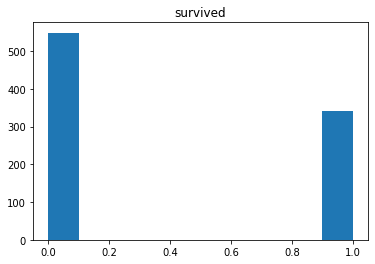

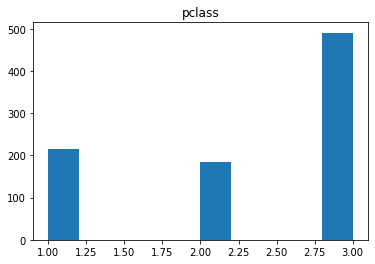

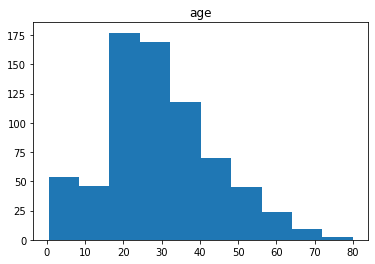

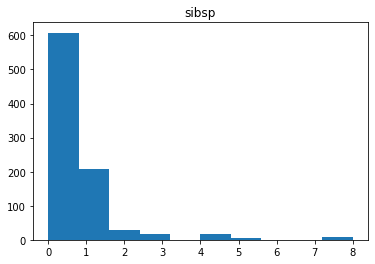

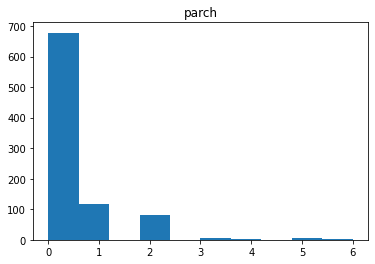

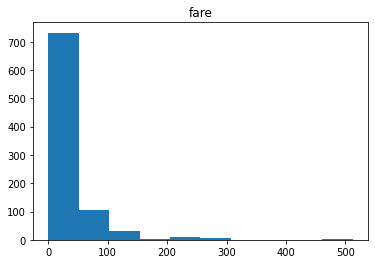

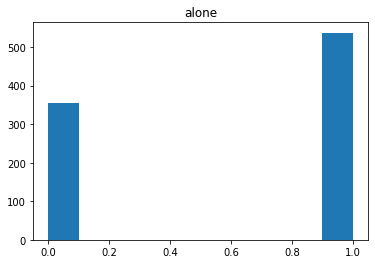

In [10]:
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [11]:
# Use .describe with object columns.
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

Index(['sex', 'embarked', 'class', 'deck', 'embark_town'], dtype='object')

In [12]:
for col in obj_cols:
    print(df[col].value_counts())
    print('\n')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')

male      577
female    314
Name: sex, dtype: int64


male      0.647587
female    0.352413
Name: sex, dtype: float64
--------------------------
S    644
C    168
Q     77
Name: embarked, dtype: int64


S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: embarked, dtype: float64
--------------------------
Third     491
First     216
Second    184
Name: class, dtype: int64


Third     0.551066
First     0.242424
Second    0.206510
Name: class, dtype: float64
--------------------------
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: deck, dtype: int64


NaN    0.772166
C      0.066218
B      0.052750
D      0.037037
E      0.035915
A      0.016835
F      0.014590
G      0.004489
Name: deck, dtype: float64
--------------------------
Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64


Southampton    0.722783
Cherbourg      0.188552
Queenstown     0.086420
NaN            0.002245
Name: embark_town, dtype: float64
-------

In [13]:
# Create bins for fare using .value_counts.
# Using sort = false will sort by bin values as opposed to the frequency counts.
df.fare.value_counts(bins=5, sort=False)

(-0.513, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(307.398, 409.863]      0
(409.863, 512.329]      3
Name: fare, dtype: int64

In [14]:
# Find columns with missing values and the total of missing values.
missing = df.isnull().sum()
missing[missing > 0]

age            177
embarked         2
deck           688
embark_town      2
dtype: int64

# STEP 2: Cleaning the Data

#### Duplicate Data?

In [15]:
# Drop duplicates...run just in case; reassign and check the shape of my data.
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(891, 13)
(891, 13)


#### Missing Data?

In [16]:
# Drop columns with too many missing values for now and reassign; check the shape of my data.
cols_to_drop = ['deck', 'embarked', 'class', 'age']
df = df.drop(columns=cols_to_drop)
df.shape

(891, 9)

In [17]:
# Validate that the columns are dropped.
df.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone
0,0,0,3,male,1,0,7.2500,Southampton,0
1,1,1,1,female,1,0,71.2833,Cherbourg,0
2,2,1,3,female,0,0,7.9250,Southampton,1
3,3,1,1,female,1,0,53.1000,Southampton,0
4,4,0,3,male,0,0,8.0500,Southampton,1


We could fill `embark_town` with most common value, 'Southampton', by hard-coding the value using the `fillna()` function, as below. Or we could use an imputer. We will demonstrate the imputer after the train-validate-test split.

In [18]:
# Run .fillna() on the entire df.
df['embark_town'] = df.embark_town.fillna(value='Southampton')

In [19]:
# Validate that missing values in embark_town have been handled.
df.embark_town.isna().sum()

0

#### Outliers?

There are a few outliers potentially in sibsp, parch, but without specific domain knowledge related to the titanic, I am not going to remove those outliers or snap them/compress them, I will ignore them for now.

#### Erroneous Values?

No erroneous values detected.

#### Correct Datatypes?

In [20]:
df.dtypes

passenger_id      int64
survived          int64
pclass            int64
sex              object
sibsp             int64
parch             int64
fare            float64
embark_town      object
alone             int64
dtype: object

#### Text Normalization?

No text normalization issues detected.

#### Tidy Data?

In [21]:
# Each column should only represent one variable
# Each row should be one observation (passenger)
df.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone
0,0,0,3,male,1,0,7.2500,Southampton,0
1,1,1,1,female,1,0,71.2833,Cherbourg,0
2,2,1,3,female,0,0,7.9250,Southampton,1
3,3,1,1,female,1,0,53.1000,Southampton,0
4,4,0,3,male,0,0,8.0500,Southampton,1


### Encoding

- Encoding -- turning a string into a number


Two strategies:
- associate each unique value with a number -- label encoding
- one-hot encoding (get_dummies): turn each unique value into a separate column with either 1 or 0

- Curse of dimensionality  
- When to use one or the other?  
    - use the label encoder when the categories have an inherit order  
    - use one-hot encoding when there is no order  

Get dummy vars for sex and embark_town (aka one hot encoding)

- dummy_na: create a dummy var for na values, also?   
- drop_first: drop first dummy var (since we know if they do not belong to any of the vars listed, then they must belong to the first one that is not listed).  

In [22]:
pd.get_dummies(df[['sex', 'embark_town']], drop_first=False, dtype=bool)

,sex_female,sex_male,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,False,True,False,False,True
1,True,False,True,False,False
2,True,False,False,False,True
3,True,False,False,False,True
4,False,True,False,False,True
...,...,...,...,...,...
886,False,True,False,False,True
887,True,False,False,False,True
888,True,False,False,False,True
889,False,True,True,False,False


In [23]:
# create dummy variables for 'sex' and 'embark_town'
dummy_df = pd.get_dummies(df[['sex', 'embark_town']], dummy_na= False, drop_first=[True, True])
dummy_df.head()

,sex_male,embark_town_Queenstown,embark_town_Southampton
0,1,0,1
1,0,0,0
2,0,0,1
3,0,0,1
4,1,0,1


In [24]:
# Concatenate the dummy_df dataframe above with the original df and validate.
df = pd.concat([df, dummy_df], axis=1)
df.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,male,1,0,7.2500,Southampton,0,1,0,1
1,1,1,1,female,1,0,71.2833,Cherbourg,0,0,0,0
2,2,1,3,female,0,0,7.9250,Southampton,1,0,0,1
3,3,1,1,female,1,0,53.1000,Southampton,0,0,0,1
4,4,0,3,male,0,0,8.0500,Southampton,1,1,0,1


#### Rename Columns?

No renaming needed at this time.

#### Scaling Data?

In [25]:
# You want to scale data when you're using methods based on measures
# of how far apart data points, like support vector machines
# or k-nearest neighbors.

### Lets not do that all over again repeatedly...lets make a function

In [26]:
def clean_data(df):
    '''
    This function will clean the data...
    '''
    df = df.drop_duplicates()
    cols_to_drop = ['deck', 'embarked', 'class', 'age']
    df = df.drop(columns=cols_to_drop)
    df['embark_town'] = df.embark_town.fillna(value='Southampton')
    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], dummy_na=False, drop_first=[True, True])
    df = pd.concat([df, dummy_df], axis=1)
    return df

Testing that the function does what we intend for it to do:

In [27]:
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [28]:
df = clean_data(df)
df.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,male,1,0,7.2500,Southampton,0,1,0,1
1,1,1,1,female,1,0,71.2833,Cherbourg,0,0,0,0
2,2,1,3,female,0,0,7.9250,Southampton,1,0,0,1
3,3,1,1,female,1,0,53.1000,Southampton,0,0,0,1
4,4,0,3,male,0,0,8.0500,Southampton,1,1,0,1


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             891 non-null    int64  
 1   survived                 891 non-null    int64  
 2   pclass                   891 non-null    int64  
 3   sex                      891 non-null    object 
 4   sibsp                    891 non-null    int64  
 5   parch                    891 non-null    int64  
 6   fare                     891 non-null    float64
 7   embark_town              891 non-null    object 
 8   alone                    891 non-null    int64  
 9   sex_male                 891 non-null    uint8  
 10  embark_town_Queenstown   891 non-null    uint8  
 11  embark_town_Southampton  891 non-null    uint8  
dtypes: float64(1), int64(6), object(2), uint8(3)
memory usage: 72.2+ KB


# Step 3: Splitting

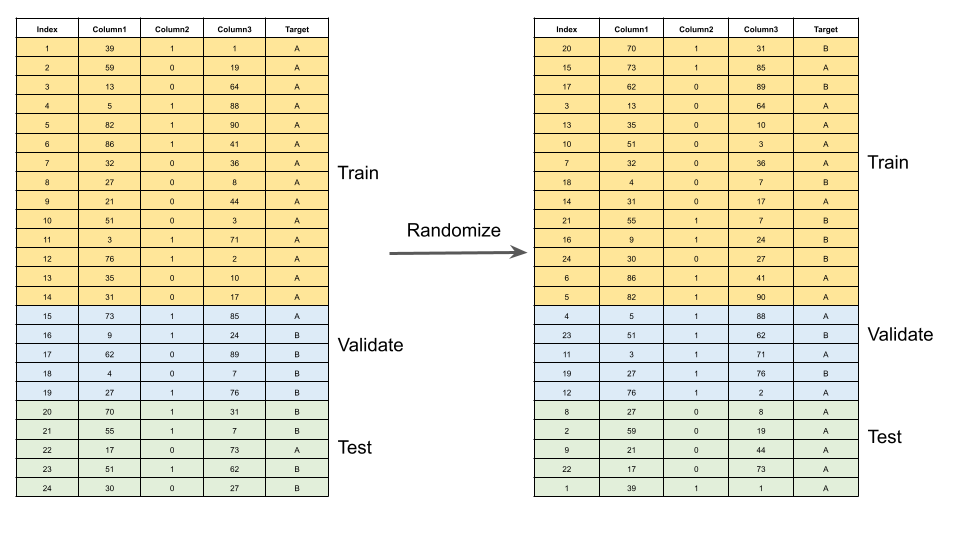

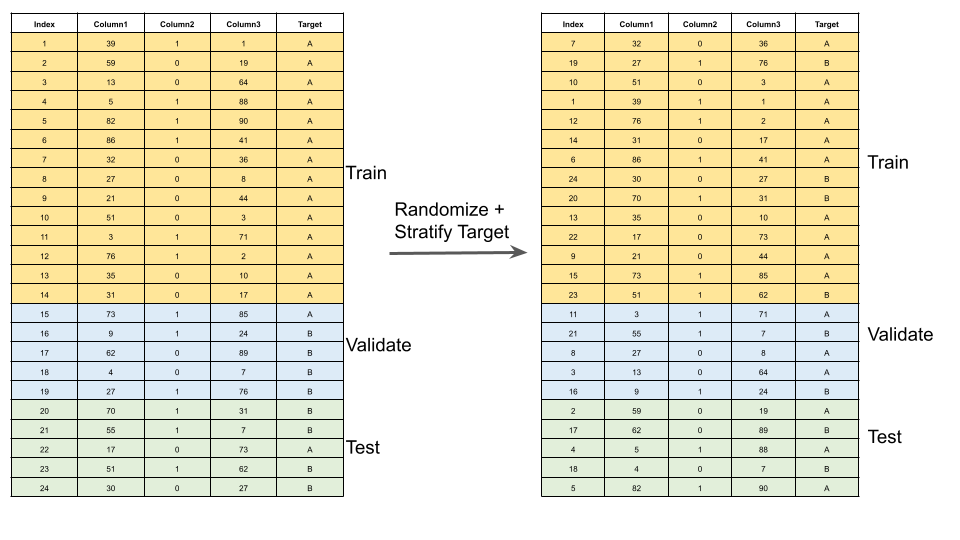

Sklearn allows us to split our data easily:  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

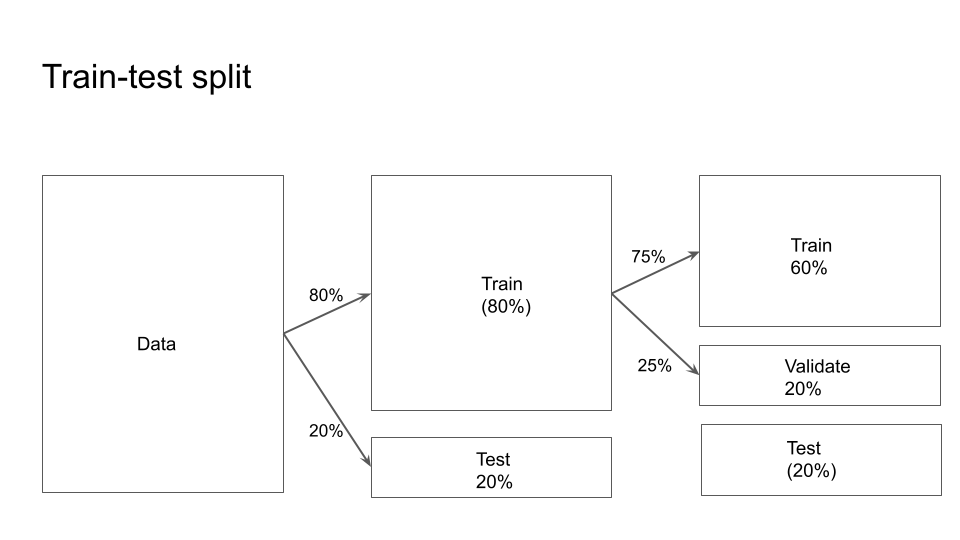

In [30]:
# 20% test, 80% train_validate
# then of the 80% train_validate: 30% validate, 70% train. 
train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df.survived)

In [31]:
print(train.shape)
print(test.shape)

(712, 12)
(179, 12)


In [32]:
train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train.survived)

In [33]:
# Observe split
print(f'Train: {train.shape}')
print(f'Validate: {validate.shape}')
print(f'Test: {test.shape}')

Train: (534, 12)
Validate: (178, 12)
Test: (179, 12)


### Turn it into a function

In [36]:
def split_data(df):
    '''
    Takes in a dataframe and return train, validate, test subset dataframes
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df.survived)
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train.survived)
    return train, validate, test

Testing that the function is doing what we intend for it to do:

In [37]:
df.shape

(891, 12)

In [41]:
train, validate, test = split_data(df)
print(f'Train: {train.shape}')
print(f'Validate: {validate.shape}')
print(f'Test: {test.shape}')

Train: (534, 12)
Validate: (178, 12)
Test: (179, 12)


# Option for Missing Values: Impute


Impute: Assign a value to something by inference


Strategies for imputing:
- fill with 0
- fill with the average
- fill with the median
- fill with subgroup mean
- fill with most frequent value
- build a model to predict missing values



We will use sklearn.imputer.SimpleImputer to do this.  

1. Create the imputer object, selecting the strategy used to impute (mean, median or mode (strategy = 'most_frequent'). 
2. Fit to train. This means compute the mean, median, or most_frequent (i.e. mode) for each of the columns that will be imputed. Store that value in the imputer object. 
3. Transform train: fill missing values in train dataset with that value identified
4. Transform validate/test: fill missing values with that value identified

Create the `SimpleImputer` object, which we will store in the variable `imputer`. In the creation of the object, we will specify the strategy to use (mean, median, most_frequent). Essentially, this is creating the instructions and assigning them to a variable, `imputer`.

In [43]:
# Define the thing:

imputer = SimpleImputer(strategy='most_frequent')
imputer

SimpleImputer(strategy='most_frequent')

`Fit` the imputer to the columns in the training df. This means that the imputer will determine the most_frequent value, or other value depending on the strategy called, for each column.

In [49]:
# fit the thing
imputer = imputer.fit(train[['embark_town']])
imputer

SimpleImputer(strategy='most_frequent')

It will store that value in the imputer object to use upon calling `transform`. We will call `transform` on our train, validate, and test datasets to fill any missing values.

In [46]:
# Use the thing (i.e transform)

train[['embark_town']] = imputer.transform(train[['embark_town']])

validate[['embark_town']] = imputer.transform(validate[['embark_town']])

test[['embark_town']] = imputer.transform(test[['embark_town']])

In [47]:
# Validate that there are no longer any Null values in embark_town.

print(train.embark_town.isnull().sum())
print(validate.embark_town.isnull().sum())
print(test.embark_town.isnull().sum())

0
0
0


### Simplify our life with a function

Note: the `clean_data()` function is already dealing with missing values. If we want to use imputation, we will need to go back and tweak our earlier function.

In [50]:
# Yay functions!
def impute_mode(train, validate, test):
    '''
    Takes in train, validate, and test, and uses train to identify the best value to replace nulls in embark_town
    Imputes that value into all three sets and returns all three sets
    '''
    imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    train[['embark_town']] = imputer.fit_transform(train[['embark_town']])
    validate[['embark_town']] = imputer.transform(validate[['embark_town']])
    test[['embark_town']] = imputer.transform(test[['embark_town']])
    return train, validate, test

### We can create a function made of our other functions

In [51]:
# Another function? YES PLZ!
def prep_titanic_data(df):
    '''
    The ultimate dishwasher
    '''
    df = clean_data(df)
    train, validate, test = split_data(df)
    return train, validate, test

In [52]:
# Acquire fresh Titanic data to test my funtion.
df = acquire.get_titanic_data()

In [53]:
# Run final prepare function and validate what that the function is working properly.
train, validate, test = prep_titanic_data(df)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 455 to 496
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             534 non-null    int64  
 1   survived                 534 non-null    int64  
 2   pclass                   534 non-null    int64  
 3   sex                      534 non-null    object 
 4   sibsp                    534 non-null    int64  
 5   parch                    534 non-null    int64  
 6   fare                     534 non-null    float64
 7   embark_town              534 non-null    object 
 8   alone                    534 non-null    int64  
 9   sex_male                 534 non-null    uint8  
 10  embark_town_Queenstown   534 non-null    uint8  
 11  embark_town_Southampton  534 non-null    uint8  
dtypes: float64(1), int64(6), object(2), uint8(3)
memory usage: 43.3+ KB


# Exercise Time